In [1]:
import pandas as pd
import numpy as np
from scipy.stats import kstest,ttest_ind
import seaborn as sns
from matplotlib.ticker import MultipleLocator
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams.update({'font.size': 14, 'axes.linewidth': 2, 'xtick.major.width': 1.5, 'xtick.major.size': 7, 'ytick.major.width': 1.5, 'ytick.major.size': 7})
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
valid_file = "/data5/deepro/ukbiobank/papers/bmi_project/4_characterization/white_british_female/data/validation/valid_mean.csv"
valid_df = pd.read_csv(valid_file)

# BMI comparison between individuals with and without the combinations in a non-white british cohort

(15.0, 50.0)

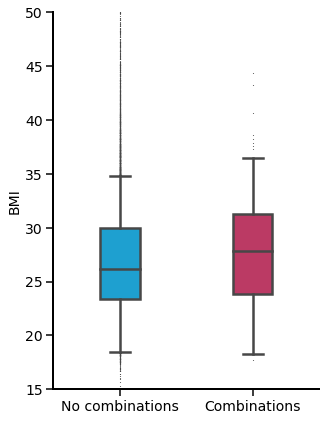

In [3]:
boxdf = valid_df

# Box Plot
sns_ax = sns.catplot(
    data=boxdf,
    palette=["#00ADEE", '#D1245D'],  # "#eecc16", "#008176" '#D1245D', '#00ADEE', '#D1245D', '#00ADEE' "#0000a7"
    kind="box",
    x="vtype",
    y="bmi",
    orient="v",
    height=6,
    aspect=0.75,
    width=0.3,
    linewidth=2.5,
    fliersize=0.25,
    whis=0.75,

    )

sns_ax.set_xlabels("")
sns_ax.set_ylabels("BMI")
sns_ax.ax.set_ylim(15, 50)

In [4]:
combo_hit_pheno = valid_df.loc[valid_df.vtype=="Combinations"]
non_combo_hit_pheno = valid_df.loc[valid_df.vtype=="No combinations"]

In [5]:
ttest_ind(non_combo_hit_pheno.bmi, combo_hit_pheno.bmi, alternative="less"), kstest(non_combo_hit_pheno.bmi, combo_hit_pheno.bmi)

(Ttest_indResult(statistic=-2.5880351719434502, pvalue=0.004830025888019251),
 KstestResult(statistic=0.15304665584864835, pvalue=0.00640798990073128))